In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import os
from reload_recursive import reload_recursive
from pyprocessmacro import Process
from statsmodels.stats.mediation import Mediation
from statsmodels.miscmodels.ordinal_model import OrderedModel
import sys

from mri_data import file_manager as fm
import helpers

In [2]:
reload_recursive(helpers)

## Setup

### Paths and Config

In [3]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = Path(os.getcwd())
data_dir = curr_dir / "data0"
showfigs = False
pd.options.display.precision = 3
colors = helpers.get_colors()

### Functions

In [ ]:
def melt_df(df, id_vars=None, value_vars=None, value_name=None, var_name=None):
    if var_name is None:
        var_name = "variable"
    if value_name is None:
        value_name = "value"

    df_melt = pd.melt(
        df,
        id_vars=id_vars,
        value_vars=value_vars,
        value_name=value_name,
        var_name=var_name,
    )

    for i, row in df_melt.iterrows():
        if "choroid" in row[var_name]:
            df_melt.loc[i, 'struct'] = "choroid"
        elif "pineal" in row[var_name]:
            df_melt.loc[i, 'struct'] = "pineal"
        elif "pituitary" in row[var_name]:
            df_melt.loc[i, 'struct'] = "pituitary"

        if "man" in row[var_name]:
            df_melt.loc[i, 'type'] = "groundtruth"
        elif "auto" in row[var_name]:
            df_melt.loc[i, 'type'] = "inference"

    return df_melt

### Load and Prepare Data

#### Model Testing

In [ ]:
analysis_dir = Path("/home/srs-9/Projects/ms_mri/analysis")
df_t1 = pd.read_csv(
    analysis_dir / "choroid_pineal_pituitary_crosstrain_t1" / "dataframe.csv",
    index_col="subid",
)
df_t1_2 = pd.read_csv(
    analysis_dir / "choroid_pineal2_pituitary_crosstrain_t1" / "dataframe.csv",
    index_col="subid",
)

df_t1 = helpers.set_dz_type5(df_t1)
df_t1_2 = helpers.set_dz_type5(df_t1_2)

#### Inference

In [ ]:
df = pd.read_csv(data_dir / "t1_data_full.csv")
df = df.set_index("subid")

keep_cols = [
    "subject",
    "age",
    "sex",
    "ms_type",
    "dzdur",
    "extracted_EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "DMT_score",
    "DMT_hx_all",
    "TER",
    "DMF",
    "NAT",
    "INF",
    "flair_contrast",
    "thalamus",
    "brain",
    "white",
    "grey",
    "cortical_thickness",
    "lesion_count",
    "lesion_vol_cubic",
    "PRL",
    "tiv",
    "choroid_volume",
    "pineal_volume",
    "pituitary_volume",
]
df = df.loc[:, keep_cols]

df = helpers.set_dz_type5(df)
df = helpers.set_dz_type3(df)
df = helpers.set_dz_type2(df)
df = helpers.fix_edss(df)
df = helpers.clean_df(df)
df = helpers.set_has_prl(df)

df.rename(columns={"lesion_vol_cubic": "t2lv"}, inplace=True)
df = df.rename(columns={"extracted_EDSS": "EDSS"})

df = helpers.do_sqrt_transform(df, ["EDSS", "MSSS", "ARMSS", "gMSSS"])
df = helpers.do_log_transform(df, ["t2lv"])

vars_to_center = [
    "EDSS_sqrt",
    "t2lv_logtrans",
    "t2lv",
    "dzdur",
    "choroid_volume",
    "PRL",
]
df = helpers.do_center(df, vars_to_center)

vars_to_scale = [
    "age",
    "dzdur",
    "lesion_count",
    "t2lv",
    "t2lv_logtrans",
    "PRL",
    "tiv",
    "choroid_volume",
    "thalamus",
]
df = helpers.do_scale(df, vars_to_scale)

numeric_vars = [
    "age",
    "dzdur",
    "Female",
    "EDSS",
    "EDSS_sqrt",
    "MSSS",
    "MSSS_sqrt",
    "gMSSS",
    "gMSSS_sqrt",
    "ARMSS",
    "ARMSS_sqrt",
    "DMT_score",
    "DMT_hx_all",
    "TER",
    "DMF",
    "NAT",
    "INF",
    "thalamus",
    "brain",
    "white",
    "grey",
    "cortical_thickness",
    "lesion_count",
    "t2lv",
    "t2lv_logtrans",
    "PRL",
    "tiv",
    "choroid_volume",
    "pineal_volume",
    "pituitary_volume",
]

for var in numeric_vars:
    df[var] = df[var].astype("float")

df_ms = df.loc[df['dz_type2'] == "MS"]
df_scale = df.copy()  # temporary till I rename df_scale everywehre
df_scale_ms = df_scale.loc[df['dz_type2'] == "MS"]

df_z = df[numeric_vars].astype("float")
df_z[df.columns[~df.columns.isin(numeric_vars)]] = df[
    df.columns[~df.columns.isin(numeric_vars)]
]
df_z = df_z[df.columns]
df_z[numeric_vars] = df_z[numeric_vars].apply(stats.zscore, nan_policy="omit")

# delete these vars once I fix all future variable references
data = df[numeric_vars].astype("float")
data_z = data[numeric_vars].apply(stats.zscore, nan_policy="omit")

data_ms = df.loc[df["dz_type5"].isin(["RMS", "PMS"]), :]
data_ms = data_ms[numeric_vars].astype("float")
data_ms_z = data_ms[numeric_vars].apply(stats.zscore, nan_policy="omit")

## Distributions

### Manual Labels

In [18]:
t1_cp_vols = melt_df(
    df_t1,
    id_vars=["dz_type5"],
    value_vars=[
        "choroid_vol_man",
        "choroid_vol_auto",
    ],
    value_name="volume",
)

t1_pin_vols = melt_df(
    df_t1,
    id_vars=["dz_type5"],
    value_vars=[
        "pineal_vol_man",
        "pineal_vol_auto",
    ],
    value_name="volume",
)

t1_pit_vols = melt_df(
    df_t1,
    id_vars=["dz_type5"],
    value_vars=[
        "pituitary_vol_man",
        "pituitary_vol_auto",
    ],
    value_name="volume",
)

<Axes: xlabel='dz_type5', ylabel='volume'>

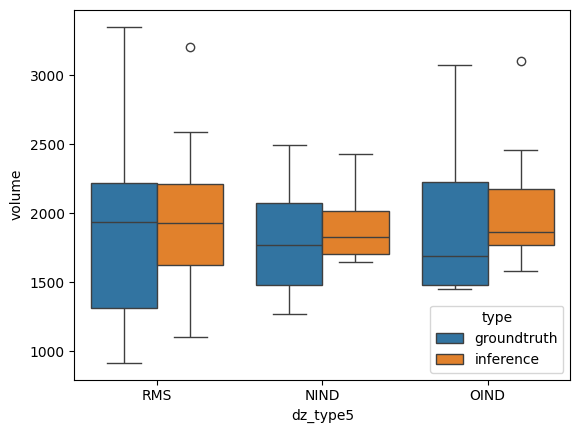

In [19]:
sns.boxplot(data=t1_cp_vols, x="dz_type5", y="volume", hue="type")